In [2]:
import os
import json
import copy
import random
import datetime
import tqdm
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss
import sklearn.metrics as sm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tensorboardX as tb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Раздел 1. Сохранение топа треков для разных рекомендеров

In [52]:
DATA_PATH = "../botify/data/data_all_recommenders/"
EXPERIMENT = "ALL_RECOMMENDERS"
recommenders = {
    "T1": "Contextual",
    "T2": "Indexed",
    "T3": "TopPop",
    "T4": "StickyArtist",
    "C": "Random",
}

data = pd.concat([
    pd.read_json(os.path.join(DATA_PATH, f"data_{i}.json"), lines=True) for i in range(4)
]).drop_duplicates(subset=["user", "track"])
data["treatment"] = data["experiments"].map(lambda experiments: experiments[EXPERIMENT])
data["rnd"] = np.random.random(len(data))

In [53]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment,rnd
0,next,2023-04-01 13:12:51.672,9830,1998,0.04,0.000511,13152.0,{'ALL_RECOMMENDERS': 'T2'},T2,0.374540
1,last,2023-04-01 13:12:51.674,1974,3399,0.00,0.000114,NaN,{'ALL_RECOMMENDERS': 'T3'},T3,0.950714
2,next,2023-04-01 13:12:51.677,9830,13152,0.96,0.000452,1488.0,{'ALL_RECOMMENDERS': 'T2'},T2,0.731994
3,next,2023-04-01 13:12:51.680,9830,1488,1.00,0.000592,1231.0,{'ALL_RECOMMENDERS': 'T2'},T2,0.598658
4,next,2023-04-01 13:12:51.702,9830,1231,0.80,0.001464,2005.0,{'ALL_RECOMMENDERS': 'T2'},T2,0.156019


In [19]:
df_recommenders = dict()
for recommender in recommenders.keys():
    df_recommenders[recommender] = data.loc[data["treatment"] == recommender].copy()

In [20]:
track_popularity = dict()
for recommender in recommenders.keys():
    df = df_recommenders[recommender] 
    track_popularity[recommender] = (
        df[df["rnd"] > 0.5]
        .groupby("track")["time"]
        .sum()
        .to_frame()
        .sort_values("time", ascending=False)
        .reset_index()
        ).copy()

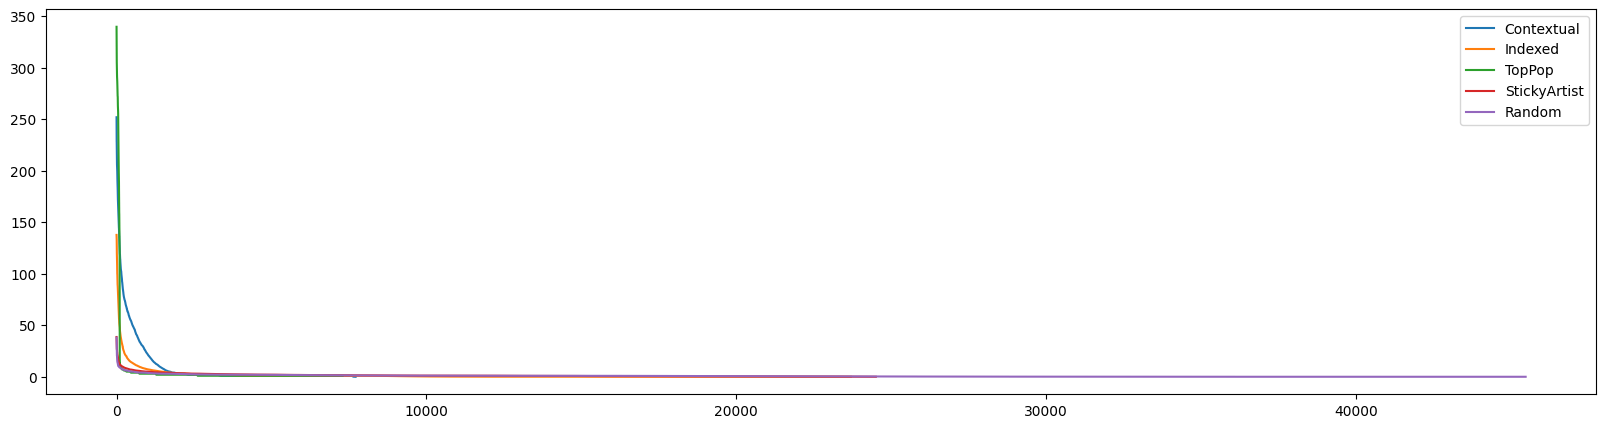

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))
for recommender in recommenders.keys():
    ax.plot(
        track_popularity[recommender].index.values, 
        track_popularity[recommender]["time"].values, 
        label=recommenders[recommender]
        )
ax.legend();

In [27]:
tracks, metrics = dict(), dict()
for recommender in recommenders.keys():
    df = df_recommenders[recommender]
    tracks[recommender] = track_popularity[recommender]["track"].tolist()
    metrics[recommender] = df[(df["rnd"] <= 0.5) & (df["time"] >= 0.75)].copy()

In [30]:
def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)


def mrr(recommendations, track):
    return 1.0 / (1 + recommendations.index(track)) if track in recommendations else 0.0

    
def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

In [31]:
for recommender in tqdm.tqdm(recommenders.keys()):
    t_p_10 = lambda track: precision_at(tracks[recommender][:10], track, 10)
    st_10_p_10 = lambda track: shuffled_precision_at(tracks[recommender][:10], track, 10)
    st_100_p_10 = lambda track: shuffled_precision_at(tracks[recommender][:100], track, 10)
    st_1000_p_10 = lambda track: shuffled_precision_at(tracks[recommender][:1000], track, 10)

    metrics[recommender]["top10_PrecAt10"] = metrics[recommender]["track"].map(t_p_10)
    metrics[recommender]["shuffledTop10_PrecAt10"] = metrics[recommender]["track"].map(st_10_p_10)
    metrics[recommender]["shuffledTop100_PrecAt10"] = metrics[recommender]["track"].map(st_100_p_10)
    metrics[recommender]["shuffledTop1000_PrecAt10"] = metrics[recommender]["track"].map(st_1000_p_10)


100%|██████████| 5/5 [00:32<00:00,  6.56s/it]


In [36]:
for recommender in recommenders.keys():
    print("-" * 80)
    print(
        recommenders[recommender], 
        metrics[recommender][["top10_PrecAt10", "shuffledTop10_PrecAt10", "shuffledTop100_PrecAt10", "shuffledTop1000_PrecAt10"]].describe(), 
        sep='\n'
        )

--------------------------------------------------------------------------------
Contextual
       top10_PrecAt10  shuffledTop10_PrecAt10  shuffledTop100_PrecAt10  \
count    70822.000000            70822.000000             70822.000000   
mean         0.002664                0.002664                 0.002221   
std          0.016104                0.016104                 0.014737   
min          0.000000                0.000000                 0.000000   
25%          0.000000                0.000000                 0.000000   
50%          0.000000                0.000000                 0.000000   
75%          0.000000                0.000000                 0.000000   
max          0.100000                0.100000                 0.100000   

       shuffledTop1000_PrecAt10  
count              70822.000000  
mean                   0.000789  
std                    0.008849  
min                    0.000000  
25%                    0.000000  
50%                    0.000000  
75%

In [42]:
for recommender in tqdm.tqdm(recommenders.keys()):
    t_mrr = lambda track: mrr(tracks[recommender][:10], track)
    st_10_mrr = lambda track: shuffled_mrr(tracks[recommender][:10], track)
    st_100_mrr = lambda track: shuffled_mrr(tracks[recommender][:100], track)
    st_1000_mrr = lambda track: shuffled_mrr(tracks[recommender][:1000], track)


    metrics[recommender]["top10_mrr"] = metrics[recommender]["track"].map(t_mrr)
    metrics[recommender]["shuffledTop10_mrr"] = metrics[recommender]["track"].map(st_10_mrr)
    metrics[recommender]["shuffledTop100_mrr"] = metrics[recommender]["track"].map(st_100_mrr)
    metrics[recommender]["shuffledTop1000_mrr"] = metrics[recommender]["track"].map(st_1000_mrr)


100%|██████████| 5/5 [00:33<00:00,  6.73s/it]


In [43]:
for recommender in recommenders.keys():
    print("-" * 80)
    print(
        recommenders[recommender], 
        metrics[recommender][["top10_mrr", "shuffledTop10_mrr", "shuffledTop100_mrr", "shuffledTop1000_mrr"]].describe(), 
        sep='\n'
        )

--------------------------------------------------------------------------------
Contextual
          top10_mrr  shuffledTop10_mrr  shuffledTop100_mrr  \
count  70822.000000       70822.000000        70822.000000   
mean       0.008064           0.007863            0.011373   
std        0.066125           0.064300            0.059995   
min        0.000000           0.000000            0.000000   
25%        0.000000           0.000000            0.000000   
50%        0.000000           0.000000            0.000000   
75%        0.000000           0.000000            0.000000   
max        1.000000           1.000000            1.000000   

       shuffledTop1000_mrr  
count         70822.000000  
mean              0.005822  
std               0.034777  
min               0.000000  
25%               0.001049  
50%               0.001572  
75%               0.003115  
max               1.000000  
--------------------------------------------------------------------------------
Indexed

In [44]:
DATA_PATH = "../botify/data/data_top_tracks/"
for recommender in recommenders.keys():
    with open(os.path.join(DATA_PATH, f"top_tracks_{recommenders[recommender]}.json"), "w") as top_tracks_file:
        json.dump(track_popularity[recommender]["track"].tolist(), top_tracks_file)

# Раздел 2. Определение лучшего топа треков

In [3]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions


def get_sessions(data):
    return (
        data
        .groupby(["user", "treatment"])
        .apply(sessionize)
        .explode()
        .apply(pd.Series)
    )


In [4]:
metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

def get_user_level_metrics(sessions):
    user_level_data = (
        sessions
        .reset_index()
        .groupby(["user", "treatment"])
        .agg(
            {
                "timestamp": "count",
                "tracks": "sum",
                "time": "sum",
                "latency": "sum"
            }
        )
    )

    user_level_data["sessions"] = user_level_data["timestamp"]
    user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
    user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
    user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

    user_level_metrics = user_level_data[metrics].copy().reset_index()
    return user_level_metrics


def get_treatment_level_metrics(user_level_metrics):
    return (
        user_level_metrics
        .groupby("treatment")[metrics]
        .agg(["count", "mean", "var"])
        )


In [5]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


def get_effects(treatment_level_metrics):
    effects = []

    control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

    for treatment, row in treatment_level_metrics.iterrows():
        if treatment == "C":
            continue
            
        for metric in metrics:
            control_mean = control[metric]["mean"]
            treatment_mean = row[metric]["mean"]
            
            effect = treatment_mean - control_mean
            conf_int = ci(
                control[metric]["count"],
                row[metric]["count"],
                control[metric]["var"],
                row[metric]["var"],
            )
            effects.append({
                "treatment": treatment,
                "metric": metric,
                "control_mean": control_mean,
                "treatment_mean": treatment_mean,
                "effect": effect / control_mean * 100,
                "lower": (effect - conf_int) / control_mean * 100,
                "upper": (effect + conf_int) / control_mean * 100,
                "significant": (effect + conf_int) * (effect - conf_int) > 0
            })

    return effects


In [6]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'


def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'


def ab_results(effects): 
    return (
        pd.DataFrame(effects)[[
            "treatment", 
            "metric",
            "effect", 
            "upper", 
            "lower", 
            "control_mean", 
            "treatment_mean",
            "significant"
        ]]
        .sort_values(["treatment"], ascending=False)
        .style
        .applymap(color, subset=["effect", "upper", "lower"])
        .applymap(background, subset=["significant"])
    )


In [10]:
DATA_PATH = "../botify/data/data_top_tracks/"
EXPERIMENT = "TOP_TRACKS_RECOMMENDERS"

data = pd.read_json(os.path.join(DATA_PATH, "data_100.json"), lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[EXPERIMENT])

sessions = get_sessions(data)
user_level_metrics = get_user_level_metrics(sessions)
treatment_level_metrics = get_treatment_level_metrics(user_level_metrics)
effects = get_effects(treatment_level_metrics)
ab_results(effects)

# T1 Top tracks on Contextual 
# T2 Top tracks on Indexed 
# T3 Top tracks on TopPop 
# T4 Top tracks on StickyArtist 
# T5 Top tracks on Random 
# C Random

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
24,T5,mean_time_per_session,65.375427,72.258576,58.492277,2.106286,3.483280,True
23,T5,mean_tracks_per_session,19.116919,21.222114,17.011725,7.116957,8.477500,True
22,T5,mean_request_latency,-54.862984,-52.591961,-57.134007,0.571089,0.257773,True
21,T5,sessions,-0.712151,2.788719,-4.213021,4.098002,4.068819,False
20,T5,time,67.705352,76.627987,58.782716,8.514382,14.279074,True
19,T4,mean_time_per_session,52.470674,58.925416,46.015931,2.106286,3.211469,True
18,T4,mean_tracks_per_session,15.566113,17.555479,13.576746,7.116957,8.224791,True
17,T4,mean_request_latency,-54.678511,-52.381517,-56.975505,0.571089,0.258826,True
16,T4,sessions,0.701979,4.281329,-2.877370,4.098002,4.126770,False
15,T4,time,56.097076,64.180666,48.013487,8.514382,13.290701,True


# Раздел 3. Определение эффекта от нового рекомендера

In [17]:
DATA_PATH = "../botify/data/data_contextual/"
EXPERIMENT = "CONTEXTUAL_TOPPOP"

data = pd.read_json(os.path.join(DATA_PATH, "data_comparison_with_contextual.json"), lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[EXPERIMENT])

sessions = get_sessions(data)
user_level_metrics = get_user_level_metrics(sessions)
treatment_level_metrics = get_treatment_level_metrics(user_level_metrics)
effects = get_effects(treatment_level_metrics)
ab_results(effects)

# T1 New recommender (Contextual + TopPop)
# C Contextual

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,31.417151,36.643286,26.191016,25.347038,33.310356,True
1,T1,sessions,-0.293109,1.672708,-2.258925,4.083093,4.071125,False
2,T1,mean_request_latency,108.710513,110.539777,106.881248,0.585128,1.221224,True
3,T1,mean_tracks_per_session,18.037295,20.651926,15.422664,11.209011,13.230814,True
4,T1,mean_time_per_session,32.683142,37.364136,28.002147,6.203796,8.231392,True


In [16]:
data = pd.read_json(os.path.join(DATA_PATH, "data_comparison_with_random.json"), lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[EXPERIMENT])

sessions = get_sessions(data)
user_level_metrics = get_user_level_metrics(sessions)
treatment_level_metrics = get_treatment_level_metrics(user_level_metrics)
effects = get_effects(treatment_level_metrics)
ab_results(effects)

# T1 New recommender (Contextual + TopPop)
# C Random

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,284.314532,297.791403,270.837661,8.708425,33.467743,True
1,T1,sessions,-1.005706,1.014509,-3.025921,4.118074,4.076659,False
2,T1,mean_request_latency,128.505429,130.566515,126.444343,0.627793,1.434540,True
3,T1,mean_tracks_per_session,85.469756,88.932535,82.006977,7.112030,13.190664,True
4,T1,mean_time_per_session,288.469774,300.055122,276.884427,2.107405,8.186633,True
